In [258]:
from hyperopt import hp, Trials, fmin, tpe
from sklearn import metrics
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
from functools import partial

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Выгрузка данных

In [259]:
with open('../data/train_data.csv', 'rb') as handle:
  train_df = pd.read_csv(handle)

with open('../data/test_data.csv', 'rb') as handle:
   test_df = pd.read_csv(handle)

#with open('../data/train_df.pkl', 'rb') as handle:
#    train_df = pickle.load(handle)

#with open('../data/test_df.pkl', 'rb') as handle:
#   test_df = pickle.load(handle)

train_df = train_df.drop(['Unnamed: 0', 'Среднесписочная_численность', 'Категория_МСП_МАЛОЕ ПРЕДПРИЯТИЕ', 'Категория_МСП_МИКРОПРЕДПРИЯТИЕ', 'Категория_МСП_Неизвестно', 'Категория_МСП_СРЕДНЕЕ ПРЕДПРИЯТИЕ'], axis=1)
test_df = test_df.drop(['Unnamed: 0', 'Среднесписочная_численность', 'Категория_МСП_МАЛОЕ ПРЕДПРИЯТИЕ', 'Категория_МСП_МИКРОПРЕДПРИЯТИЕ', 'Категория_МСП_Неизвестно', 'Категория_МСП_СРЕДНЕЕ ПРЕДПРИЯТИЕ'], axis=1)


# Анализ данных и оценка выбросов

Обучающая выборка: (10500, 128)
Тестовая выборка: (4500, 127)

## Пропущенные значения в обучающей выборке:
Series([], dtype: int64)

## Пропущенные значения в тестовой выборке:
Series([], dtype: int64)

## Распределение целевой переменной:
Класс 0 (Не дефолт): 74.41%
Класс 1 (Дефолт): 25.59%


/var/folders/7s/gqt97bkd51x6c8kxzq2wlr280000gn/T/ipykernel_4359/1007690081.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=train_df, palette=['skyblue', 'salmon'])


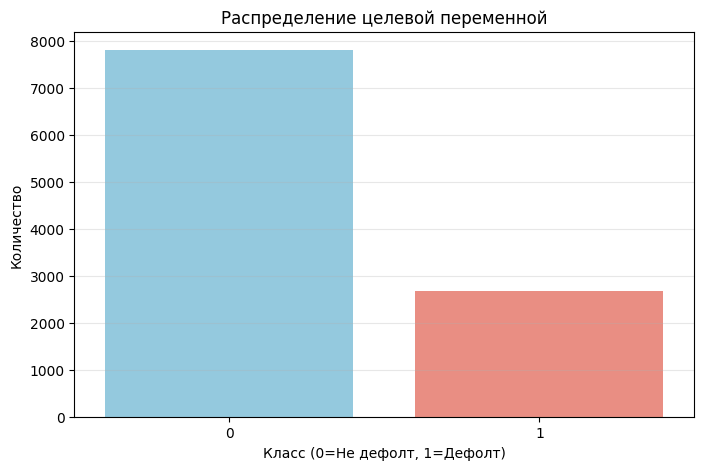


## Обнаружение выбросов (Метод IQR)

### Выбросы в обучающей выборке:
Топ-10 признаков с наибольшим процентом выбросов в обучающей выборке:
                 Признак  Количество выбросов  Процент выбросов
3      data_УстКап_Сумма                 2086         19.866667
103          2200_growth                 1947         18.542857
15    Максимальная_сумма                 1786         17.009524
13           Общая_сумма                 1735         16.523810
102            2200_mean                 1723         16.409524
39           2020_2200_0                 1723         16.409524
16   Последнее_дело_дата                 1715         16.333333
80           2024_2400_0                 1709         16.276190
70           2023_2400_0                 1664         15.847619
81           2024_2400_1                 1663         15.838095

### Выбросы в тестовой выборке:
Топ-10 признаков с наибольшим процентом выбросов в тестовой выборке:
                 Признак  Количество выбросов  Процен

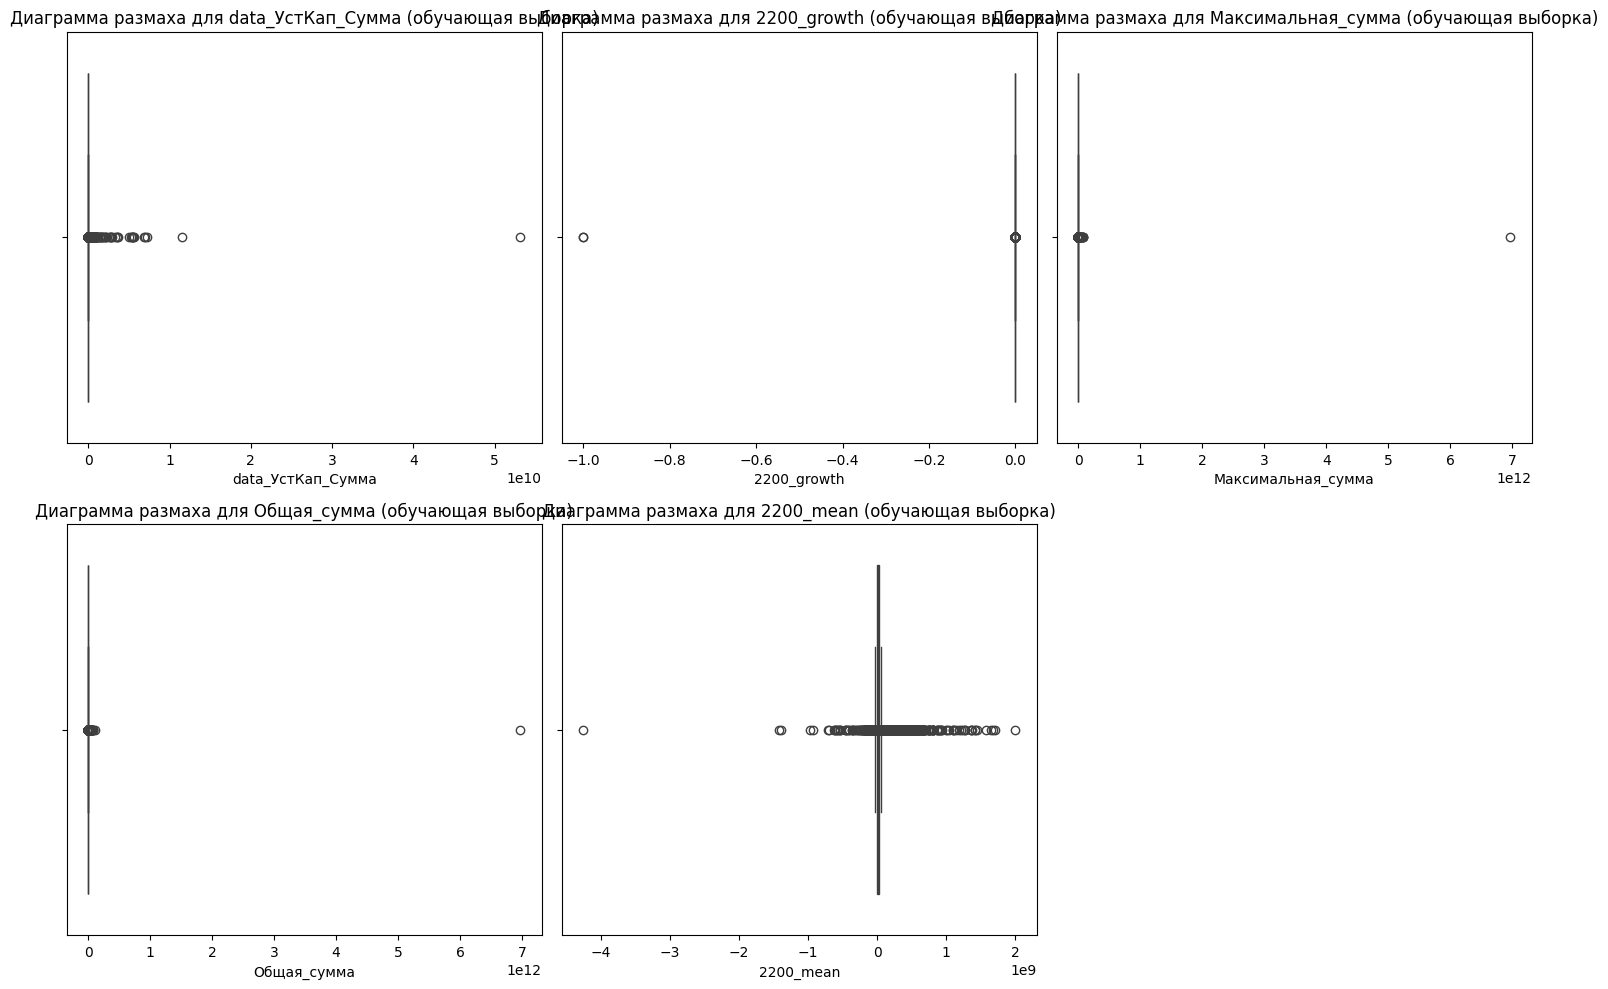


## Корреляция с целевой переменной (обучающая выборка)

Признаки с наибольшей корреляцией с целевой переменной:
target                            1.000000
status_Деятельность прекращена    0.428259
status_Процесс банкротства        0.321298
status_Процесс реорганизации      0.306203
Есть_банкротство                  0.298877
status_Стадия ликвидации          0.225202
tax_arrears_ratio                 0.198676
status_Процесс исключения         0.105448
data_Налоги_СумНедоим             0.070286
2020_1500_0                       0.057748
Name: target, dtype: float64

Признаки с наименьшей корреляцией с целевой переменной:
2024_2400_0                      -0.069754
2022_1300_0                      -0.069975
2023_1300_1                      -0.071046
1300_mean                        -0.072844
2023_1300_0                      -0.076473
roa                              -0.166715
altman_t2                        -0.166715
equity_ratio                     -0.206192
status_Действующая организа

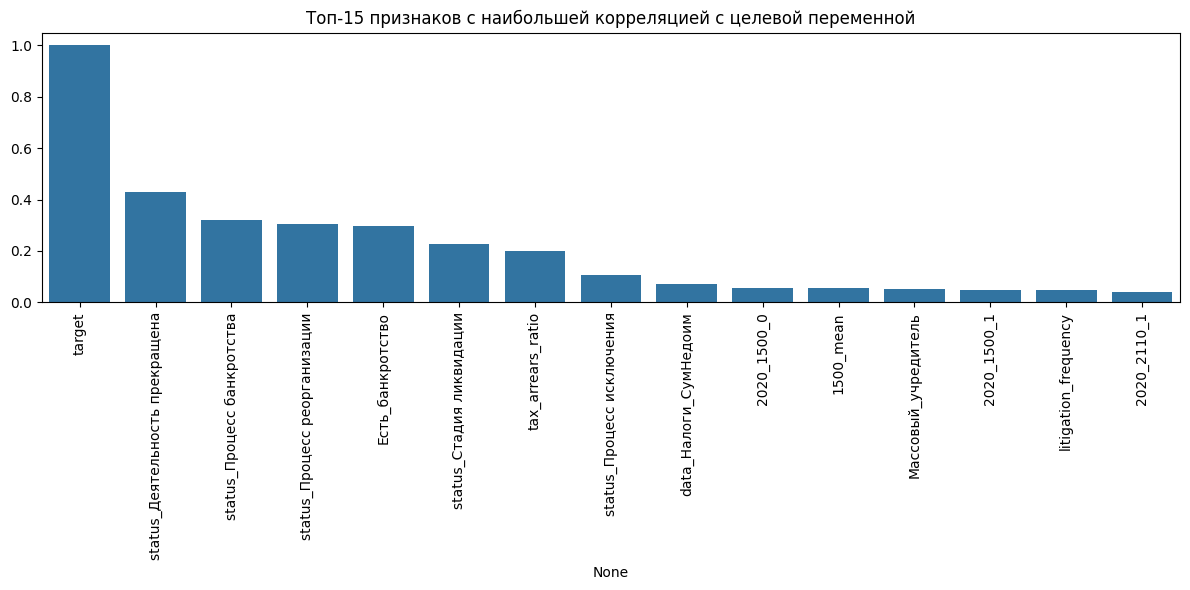

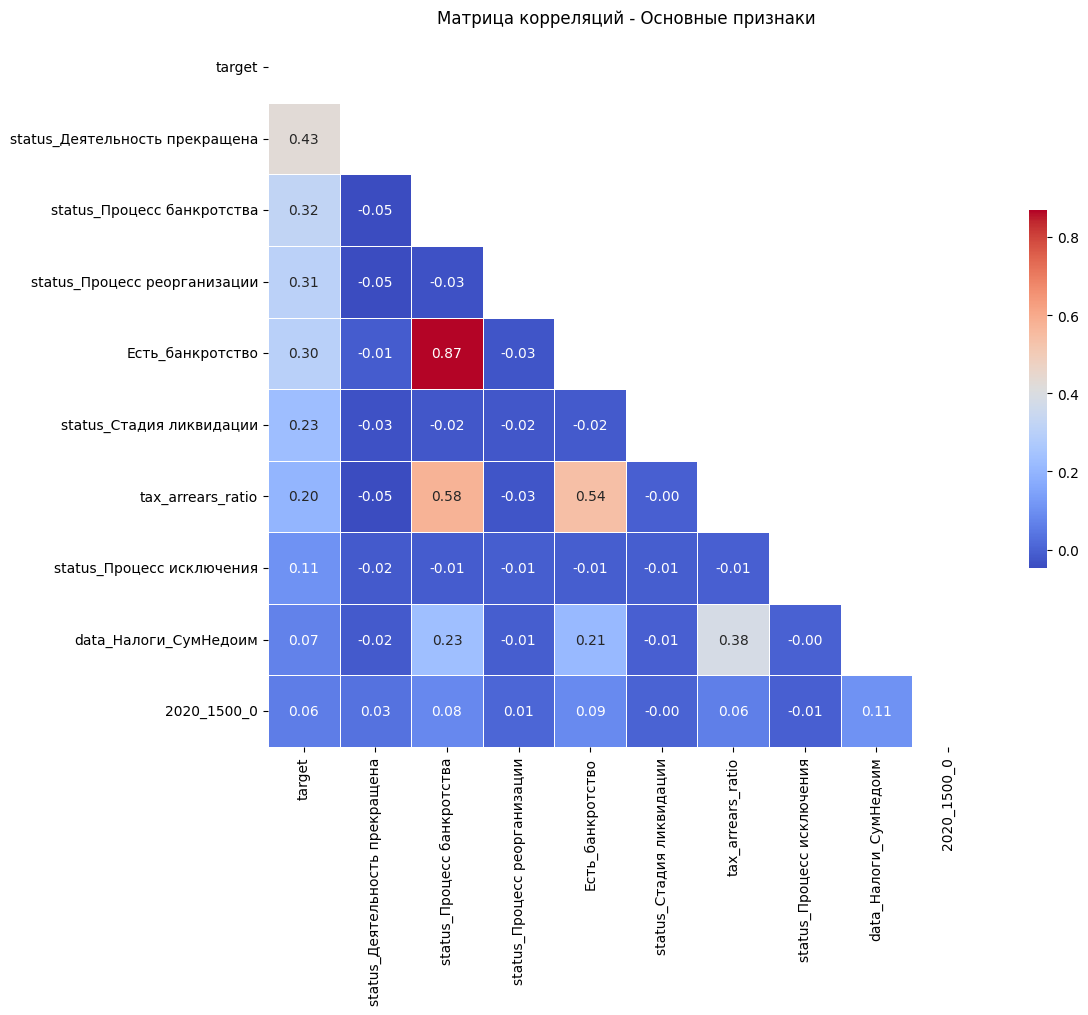


## Распределение основных числовых признаков


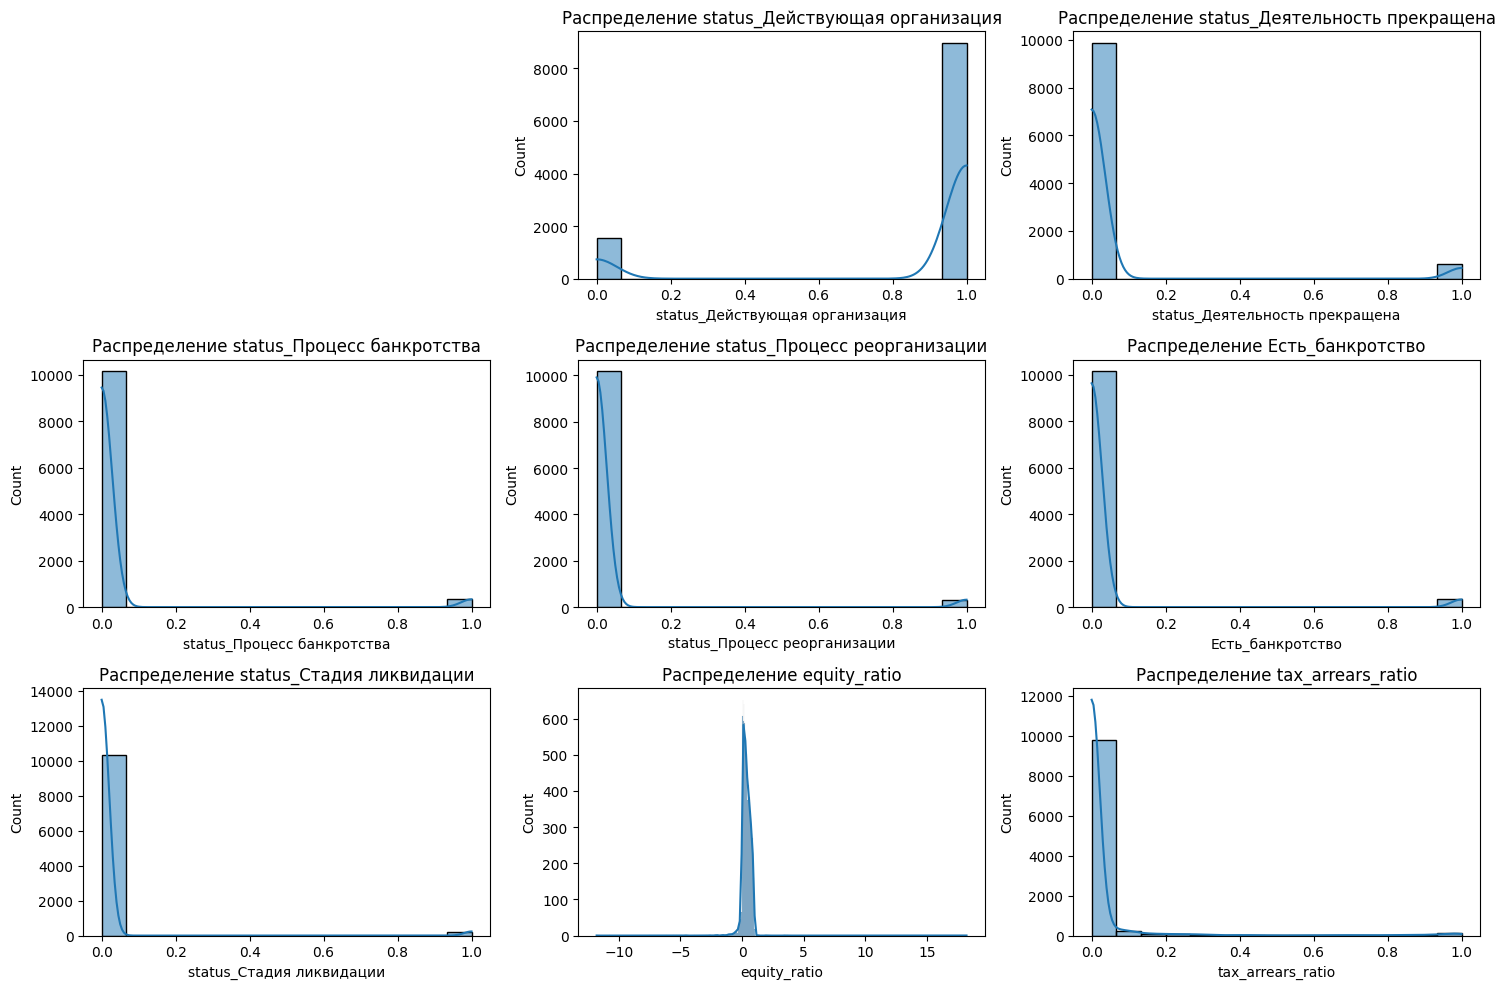

In [236]:
print("Обучающая выборка:", train_df.shape)
print("Тестовая выборка:", test_df.shape)

print("\n## Пропущенные значения в обучающей выборке:")
missing_train = train_df.isnull().sum()
print(missing_train[missing_train > 0].sort_values(ascending=False).head(10))

print("\n## Пропущенные значения в тестовой выборке:")
missing_test = test_df.isnull().sum()
print(missing_test[missing_test > 0].sort_values(ascending=False).head(10))

if 'target' in train_df.columns:
    print("\n## Распределение целевой переменной:")
    target_counts = train_df['target'].value_counts(normalize=True) * 100
    print(f"Класс 0 (Не дефолт): {target_counts[0]:.2f}%")
    print(f"Класс 1 (Дефолт): {target_counts[1]:.2f}%")

    plt.figure(figsize=(8, 5))
    sns.countplot(x='target', data=train_df, palette=['skyblue', 'salmon'])
    plt.title('Распределение целевой переменной')
    plt.xlabel('Класс (0=Не дефолт, 1=Дефолт)')
    plt.ylabel('Количество')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

print("\n## Обнаружение выбросов (Метод IQR)")
def detect_outliers_iqr(df, is_train=True):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    outliers_dict = {}
    
    for col in numeric_cols:
        if is_train and col == 'target':
            continue
            
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        if outliers > 0:
            outliers_dict[col] = {
                'count': outliers,
                'percentage': outliers / len(df) * 100,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
    
    return outliers_dict

print("\n### Выбросы в обучающей выборке:")
outliers_train = detect_outliers_iqr(train_df, is_train=True)
outliers_train_df = pd.DataFrame({
    'Признак': list(outliers_train.keys()),
    'Количество выбросов': [outliers_train[col]['count'] for col in outliers_train],
    'Процент выбросов': [outliers_train[col]['percentage'] for col in outliers_train]
})

print("Топ-10 признаков с наибольшим процентом выбросов в обучающей выборке:")
top_outliers_train = outliers_train_df.sort_values('Процент выбросов', ascending=False).head(10)
print(top_outliers_train)

print("\n### Выбросы в тестовой выборке:")
outliers_test = detect_outliers_iqr(test_df, is_train=False)
outliers_test_df = pd.DataFrame({
    'Признак': list(outliers_test.keys()),
    'Количество выбросов': [outliers_test[col]['count'] for col in outliers_test],
    'Процент выбросов': [outliers_test[col]['percentage'] for col in outliers_test]
})

print("Топ-10 признаков с наибольшим процентом выбросов в тестовой выборке:")
top_outliers_test = outliers_test_df.sort_values('Процент выбросов', ascending=False).head(10)
print(top_outliers_test)

plt.figure(figsize=(15, 10))
top_outlier_features_train = top_outliers_train['Признак'].head(5).values
for i, feature in enumerate(top_outlier_features_train):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=train_df[feature])
    plt.title(f'Диаграмма размаха для {feature} (обучающая выборка)')
    plt.tight_layout()
plt.show()

if 'target' in train_df.columns:
    print("\n## Корреляция с целевой переменной (обучающая выборка)")
    numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
    correlations = train_df[numeric_cols].corr()['target'].sort_values(ascending=False)
    
    print("\nПризнаки с наибольшей корреляцией с целевой переменной:")
    print(correlations.head(10))
    
    print("\nПризнаки с наименьшей корреляцией с целевой переменной:")
    print(correlations.tail(10))
    
    # Визуализация корреляций
    plt.figure(figsize=(12, 6))
    sns.barplot(x=correlations.head(15).index, y=correlations.head(15).values)
    plt.title('Топ-15 признаков с наибольшей корреляцией с целевой переменной')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    top_features = correlations.head(10).index.tolist()
    if 'target' not in top_features:
        top_features.append('target')
        
    plt.figure(figsize=(12, 10))
    corr_matrix = train_df[top_features].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Матрица корреляций - Основные признаки')
    plt.tight_layout()
    plt.show()

print("\n## Распределение основных числовых признаков")

if 'target' in train_df.columns:
    top_numeric_features = correlations.abs().sort_values(ascending=False).head(9).index.tolist()
    
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(top_numeric_features):
        if feature != 'target':
            plt.subplot(3, 3, i+1)
            sns.histplot(train_df[feature], kde=True)
            plt.title(f'Распределение {feature}')
    plt.tight_layout()
    plt.show()
else:
    numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
    top_numeric_features = numeric_cols[:9]
    
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(top_numeric_features):
        plt.subplot(3, 3, i+1)
        sns.histplot(train_df[feature], kde=True)
        plt.title(f'Распределение {feature}')
    plt.tight_layout()
    plt.show()

# Подготовка данных для обучения

In [237]:
X, y = train_df.drop(columns=['target']), train_df['target']

## Заполнение пропущенных значений

In [238]:
imputer = SimpleImputer(strategy="most_frequent")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

## Кодирование категориальных переменных

In [239]:
cat_cols = X.select_dtypes(include='object').columns
if len(cat_cols) > 0:
    encoder = OrdinalEncoder()
    X[cat_cols] = encoder.fit_transform(X[cat_cols])


## Обработка числовых признаков

In [240]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
X_transformed = X.copy()

for col in num_cols:
    if (X[col] <= 0).any():
        min_val = X[col].min()
        if min_val <= 0:
            X_transformed[col] = np.log(X[col] - min_val + 1)
    else:
        X_transformed[col] = np.log(X[col])

## Маштабирование

In [241]:
scaler = StandardScaler()
X_transformed[num_cols] = scaler.fit_transform(X_transformed[num_cols])
X = X_transformed

## Отбор признаков

In [242]:
selector_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=500)
selector = SelectFromModel(selector_model, threshold="median")
selector.fit(X, y)

X_selected = selector.transform(X)
selected_feature_indices = selector.get_support(indices=True)
feature_names = X.columns[selector.get_support()].tolist()

print(f"Выбрано признаков: {X_selected.shape[1]} из {X.shape[1]}")

Выбрано признаков: 64 из 127


## Разбиение датачета на обучающую и валидационную выборку

In [243]:
X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size = 0.2, random_state = 1)

## Упрощенная модель XGBoost

In [244]:
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_val, y_val, enable_categorical=True)

In [245]:
def train_simplified_xgb(X_train, y_train, X_val, y_val):
    params = {
        'n_estimators': 100,
        'max_depth': 5,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'seed': 42,
        'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        'early_stopping_rounds':20
    }
    
    # Обучение модели
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=True
    )
    
    return model

## Обучение упрощенной модели XGBoost

In [246]:
simple_xgb_model = train_simplified_xgb(X_train, y_train, X_val, y_val)

[0]	validation_0-auc:0.89381
[1]	validation_0-auc:0.89587
[2]	validation_0-auc:0.90780
[3]	validation_0-auc:0.91339
[4]	validation_0-auc:0.91299
[5]	validation_0-auc:0.91499
[6]	validation_0-auc:0.91440
[7]	validation_0-auc:0.91537
[8]	validation_0-auc:0.91636
[9]	validation_0-auc:0.91858
[10]	validation_0-auc:0.91716
[11]	validation_0-auc:0.91783
[12]	validation_0-auc:0.91843
[13]	validation_0-auc:0.92121
[14]	validation_0-auc:0.92319
[15]	validation_0-auc:0.92265
[16]	validation_0-auc:0.92205
[17]	validation_0-auc:0.92310
[18]	validation_0-auc:0.92466
[19]	validation_0-auc:0.92485
[20]	validation_0-auc:0.92421
[21]	validation_0-auc:0.92449
[22]	validation_0-auc:0.92570
[23]	validation_0-auc:0.92594
[24]	validation_0-auc:0.92652
[25]	validation_0-auc:0.92675
[26]	validation_0-auc:0.92684
[27]	validation_0-auc:0.92674
[28]	validation_0-auc:0.92754
[29]	validation_0-auc:0.92741
[30]	validation_0-auc:0.92710
[31]	validation_0-auc:0.92728
[32]	validation_0-auc:0.92720
[33]	validation_0-au

## Оценка модели XGBoost

In [247]:
xgb_preds = simple_xgb_model.predict(X_val)

In [248]:
accuracy = metrics.accuracy_score(y_val, xgb_preds > 0.5)

print(f"Точность на тестовых данных: {accuracy}")

Точность на тестовых данных: 0.9142857142857143


## Оценка метрик

ROC AUC Score: 0.8476190476190476


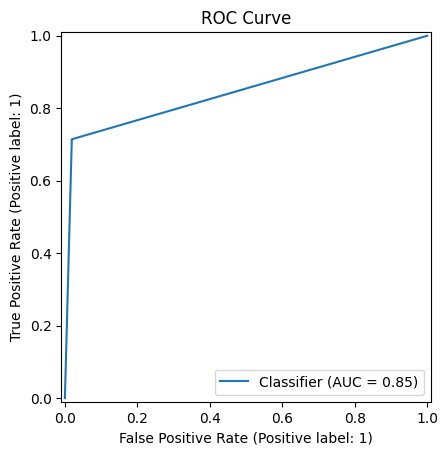

Gini Coefficient: 0.6952380952380952
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      1575
           1       0.93      0.71      0.81       525

    accuracy                           0.91      2100
   macro avg       0.92      0.85      0.88      2100
weighted avg       0.92      0.91      0.91      2100

Confusion Matrix:
 [[1545   30]
 [ 150  375]]


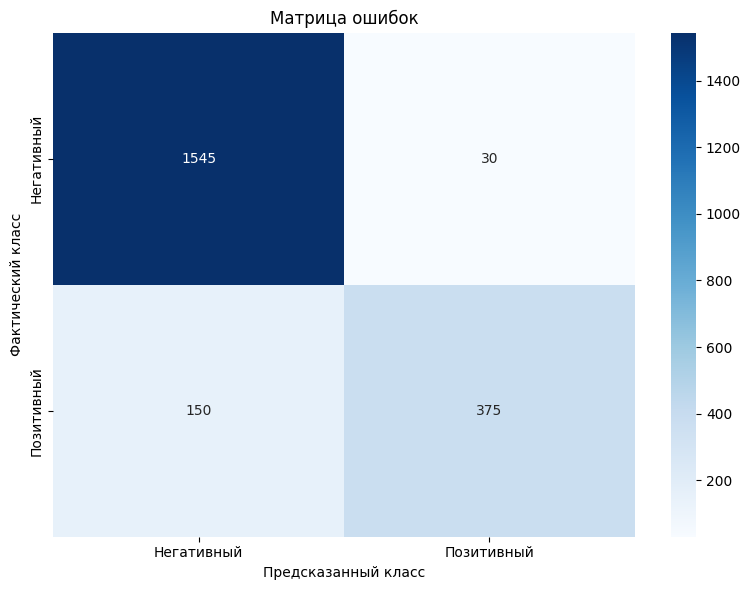

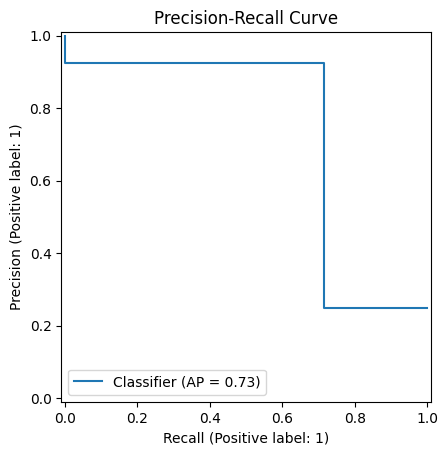

In [249]:
roc_auc = roc_auc_score(y_val, xgb_preds)
print("ROC AUC Score:", roc_auc)

RocCurveDisplay.from_predictions(y_val, xgb_preds)
plt.title("ROC Curve")
plt.show()

gini = 2 * roc_auc - 1
print("Gini Coefficient:", gini)


print("Classification Report:\n", classification_report(y_val, xgb_preds))

confusion_matrix = confusion_matrix(y_val, xgb_preds)
print("Confusion Matrix:\n", confusion_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Негативный', 'Позитивный'],
            yticklabels=['Негативный', 'Позитивный'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()


PrecisionRecallDisplay.from_predictions(y_val, xgb_preds)
plt.title("Precision-Recall Curve")
plt.show()

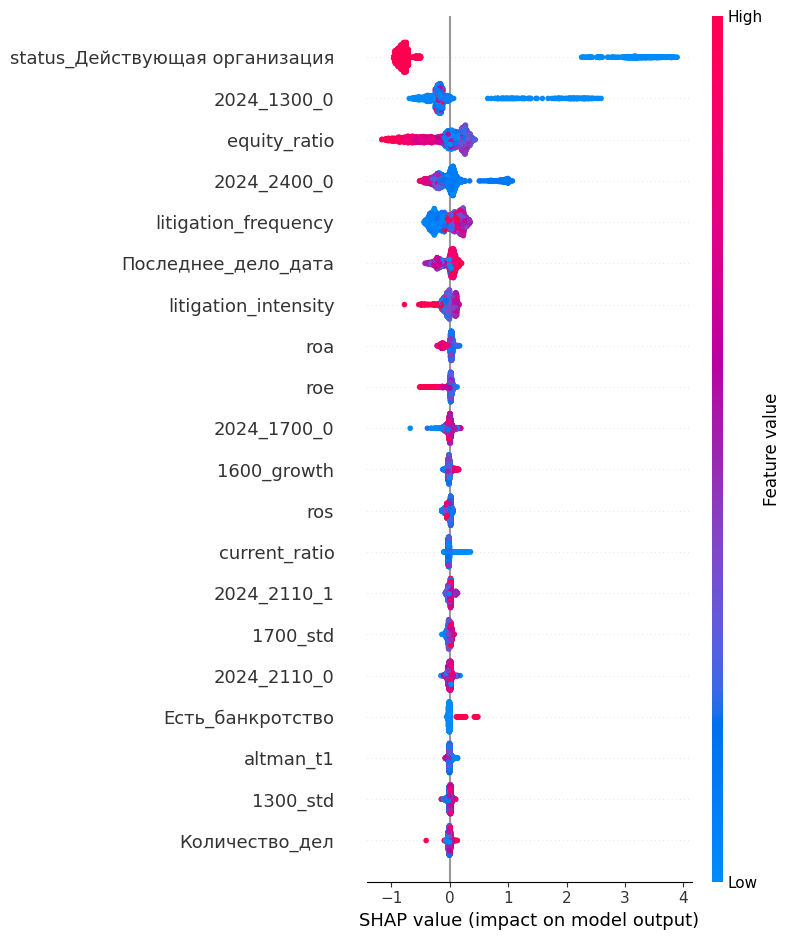

In [250]:
explainer = shap.Explainer(simple_xgb_model)
shap_values = explainer(X_val)

feature_names = X.columns[selector.get_support()].tolist()

plt.figure(figsize=(10, 12))
shap.summary_plot(shap_values, X_val, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()

# Постобработка для дальнейшей работы с моделью

In [251]:
test_df_processed = pd.DataFrame(imputer.transform(test_df), columns=test_df.columns)

if len(cat_cols) > 0:
    test_df_processed[cat_cols] = encoder.transform(test_df_processed[cat_cols])
    
test_df_processed[num_cols] = scaler.transform(test_df_processed[num_cols])

X_test_final = selector.transform(test_df_processed)

real_predictions = simple_xgb_model.predict(X_test_final)
real_proba_predictions = simple_xgb_model.predict_proba(X_test_final)

In [252]:
result = pd.DataFrame({'inn': test_df['inn'],
                       'target': real_predictions})

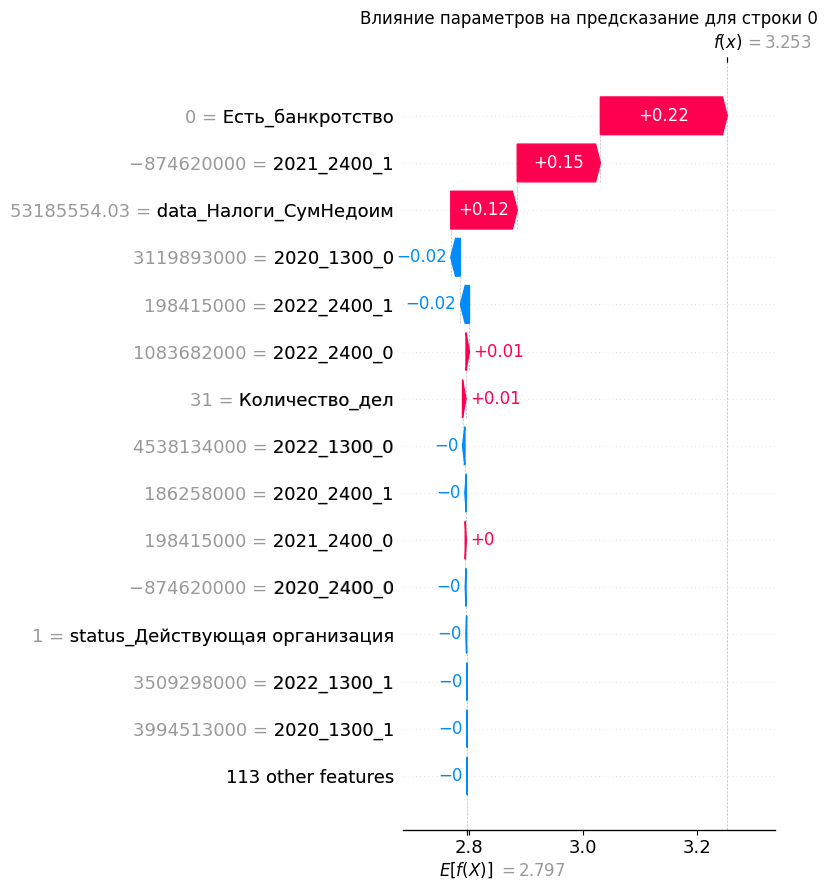

Значения признаков для строки (отсортированы по силе влияния):
status_Действующая организация: 0.0 (SHAP влияние: 0.2223) - увеличивает вероятность
roa: -874620000.0 (SHAP влияние: 0.1456) - увеличивает вероятность
Есть_банкротство: 53185554.03 (SHAP влияние: 0.1165) - увеличивает вероятность
2024_1300_0: 3119893000.0 (SHAP влияние: -0.0169) - уменьшает вероятность
litigation_intensity: 198415000.0 (SHAP влияние: -0.0159) - уменьшает вероятность


/var/folders/7s/gqt97bkd51x6c8kxzq2wlr280000gn/T/ipykernel_4359/1498340746.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_data[i],


In [253]:
explainer = shap.Explainer(simple_xgb_model, test_df) 
shap_values = explainer(test_df)

row_index = 0
row_shap_values = shap_values[row_index]

row_shap_values.feature_names = test_df.columns.tolist()
row_data = test_df.iloc[row_index]

# Визуализация
plt.figure(figsize=(12, 6))
shap.plots.waterfall(row_shap_values, max_display=15, show=False)
plt.title(f'Влияние параметров на предсказание для строки {row_index}')
plt.tight_layout()
plt.show()

feature_impact = []
for i, feature in enumerate(feature_names):
    if i < len(row_shap_values.values):
        feature_impact.append((
            feature, 
            row_data[i], 
            row_shap_values.values[i]
        ))

feature_impact.sort(key=lambda x: abs(x[2]), reverse=True)

print("Значения признаков для строки (отсортированы по силе влияния):")
for feature, value, shap_value in feature_impact[:5]:
    # Определяем направление влияния
    direction = "увеличивает" if shap_value > 0 else "уменьшает"
    print(f"{feature}: {value} (SHAP влияние: {shap_value:.4f}) - {direction} вероятность")

In [254]:
top5_features_per_row = []

for idx in range(len(test_df)):
    row_data = test_df.iloc[idx]
    row_shap = shap_values[idx]

    shap_vals = row_shap.values
    feature_names = X.columns.tolist()
    min_len = min(len(feature_names), len(shap_vals))

    feature_impact = []
    for i in range(min_len):
        feature_impact.append((
            feature_names[i],
            row_data[feature_names[i]],
            shap_vals[i]
        ))

    top5 = sorted(feature_impact, key=lambda x: abs(x[2]), reverse=True)[:5]
    top5_features_per_row.append(top5)

test_df = test_df.copy()  
test_df["top5_features"] = top5_features_per_row

In [255]:
import re 

columns_to_drop = [col for col in test_df.columns if re.match(r'20\d{2}_\d{4}_\d+' or r'^\d{4}_(?:mean|std|growth)$', col)]
test_df = test_df.drop(columns=columns_to_drop)

test_df['prdiction'] = real_proba_predictions[:,1]
test_df.shape

(4500, 73)

In [256]:
result.to_csv('../results/test_predictions.csv', index=False)
test_df.to_json('../results/table_predictions.json', index=False)

In [257]:
with open('../results/checkpoints_V0.pkl', 'wb') as handle:
    pickle.dump(simple_xgb_model, handle)